<a href="https://colab.research.google.com/github/Mayuri103120/DL_Learnings/blob/main/DL_lab2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Goal: To Visualize and Undersatnd different optimizers in DL

1. Gradient Descent
2. Newton's Method
3. Momentum
4. ADAM

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import cm
import torch

%matplotlib inline

Loss function is $f(x,y) = ax^2 + by^2 + cxy + dx +ey$

In [3]:
class QuadFunc:
  def __init__(self,a, b, c, d, e):
    self.a = a
    self.b = b
    self.c = c
    self.d = d
    self.e = e

  def getParams(self, x, y):
    if y is None:
      y =x[1]
      x = x[0]
    return x,y

  def __call__(self, x, y = None):
    x,y = self.getParams(x,y)
    return 0.5 * (self.a*x**2 + self.b*y**2) + self.c * x * y + self.d *x +self.e*y

#Computing gradient and hessian without backpropagation method just the basic calculus:
  def grad(self, x, y = None):
    x, y = self.getParams(x,y)
    return torch.tensor([self.a * x + self.c *y +self.d, self.b * y + self.c * x + self.e])

  def hess (self, x, y=None):
    x, y = self.getParams(x,y)
    return torch.tensor([[self.a, self.c], [self.c, self.b]])

class GradientDescent:
  #b1 --> Momentum
  #b2 --> ADAM
  def __init__(self, lr =1, b1=0.9, b2 = 0.999):
    self.lr = lr
    self.b1 = b1
    self.b2 = b2

    self.v = 0
    self.w = 0
    self.t = 0

    self.eps = 1e-9

  def __call__(self, grad, hess):
    self.t += 1
    self.v = self.b1*self.v + (1-self.b1)*grad
    self.w = self.b2*self.w + (1-self.b2)*grad**2

    vcorr = self.v/ (1-self.b1**self.t)
    wcorr = self.w/ (1-self.b2**self.t) if self.b2 != 0 else 1
    return -1*self.lr*vcorr/(wcorr**0.5 + self.eps)

class Newtons:
  def __init__(self, lr=1):
    self.lr = lr

  def __call__(self, grad,hess):
    return -1*self.lr*torch.matmul(torch.inverse(hess), grad)

def runOptim(init, optim, func,steps):
  curpos = init #current position
  path = [curpos]

  for _ in range(steps):
    grad = func.grad(curpos)
    hess = func.hess(curpos)

    dx = optim(grad, hess)
    curpos = curpos + dx
    path.append(curpos)

  return path

def showPath(func, init, paths, labels, colors,levels):
  x = torch.arange(-10,10,0.05)
  y = torch.arange(-10,10,0.05)

#create meshgrid
  xx, yy = torch.meshgrid(x,y)
  zz = func(xx,yy)

#create contour
  fig, ax = plt.subplots(1,1,figsize=(16,10))
  cp = ax.contourf(xx,yy,zz,levels)
  fig.colorbar(cp)

#mark initial point
  ax.plot(init[0],init[1],'ro')
  ax.text(init[0]+0.5,init[1]+0.5,'Initial Point', color ='white')

#plot paths
  for pnum in range(len(paths)):
    for i in range(len(paths[pnum])-1):
      curpos = paths[pnum][i]
      d = paths[pnum][i+1] - curpos
      ax.arrow(curpos[0], curpos[1],d[0],d[1],color=colors[pnum],head_width=0.2)
      ax.text(curpos[0]+d[0], curpos[1]+d[1],str(i),color='white')

#add legend
  legends = []
  for col in colors:
    legends.append(mpatches.Patch(color=col))
  ax.legend(legends,labels)

1. Gradient Descent using a simple convex function, $f(x,y) = x^2 + y^2$

/usr/local/lib/python3.8/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


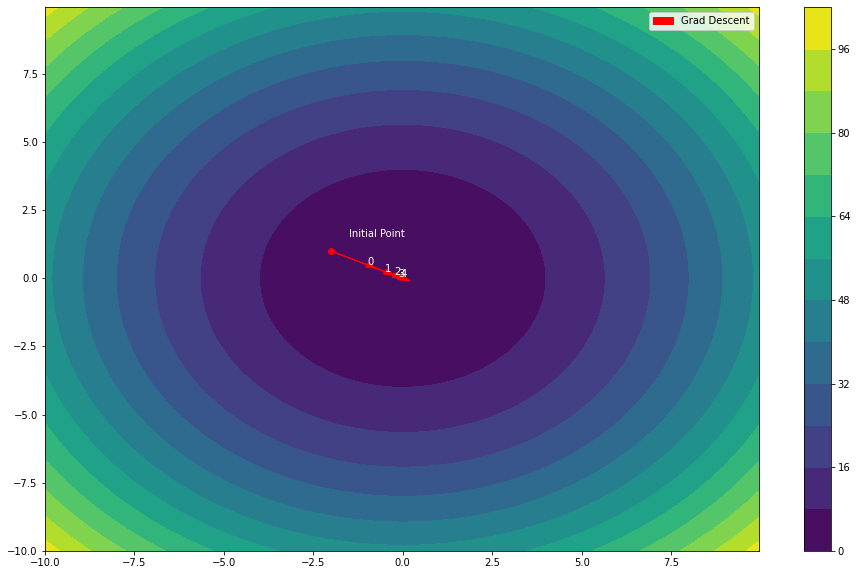

In [4]:
f = QuadFunc(a= 1.0, b=1.0, c=0., d=0., e=0.) #instantiate quad function class
init = torch.tensor([-2.0,1.0]) #Starting points
regGD = GradientDescent(lr = 0.5, b1=0, b2=0) #instantiate gradient descent class, turned off momentum and ADAM
steps = 5
path = runOptim(init, regGD, f, steps)
showPath(f, init, [path], ['Grad Descent'], ['r'], levels=15)

2. Gradient Descent using $f(x,y) = x^2 - y^2$ with a saddle point

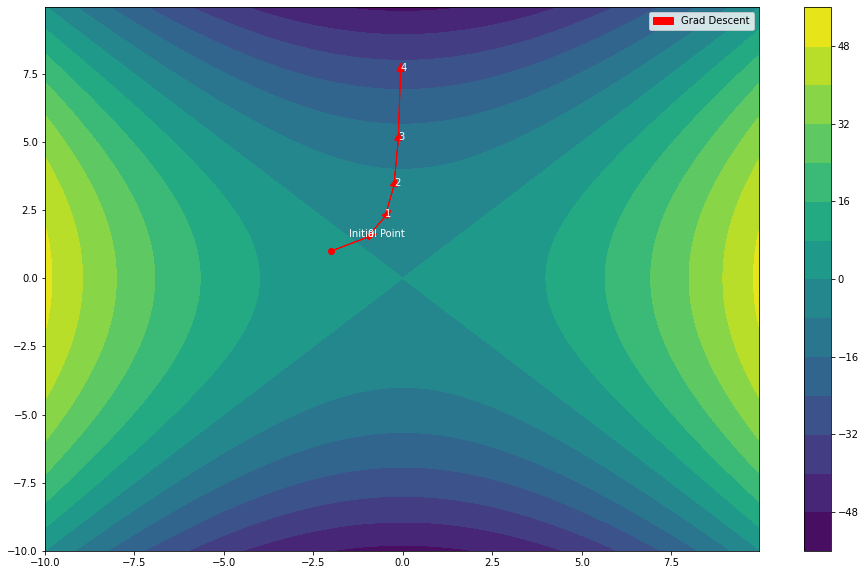

In [9]:
f = QuadFunc(a= 1.0, b= -1.0, c=0., d=0., e=0.) #instantiate quad function class
init = torch.tensor([-2.0,1.0]) #Starting points
regGD = GradientDescent(lr = 0.5, b1=0, b2=0) #instantiate gradient descent class, turned off momentum and ADAM
steps = 5
path = runOptim(init, regGD, f, steps)
showPath(f, init, [path], ['Grad Descent'], ['r'], levels=15)

In the above case the minima is sloping off to -ve infinity instead of zero which is a desired output. However, if the initialization points are changed to y = 0 and x =-2, the vanilla gradient descent takes us to the saddle point instead.

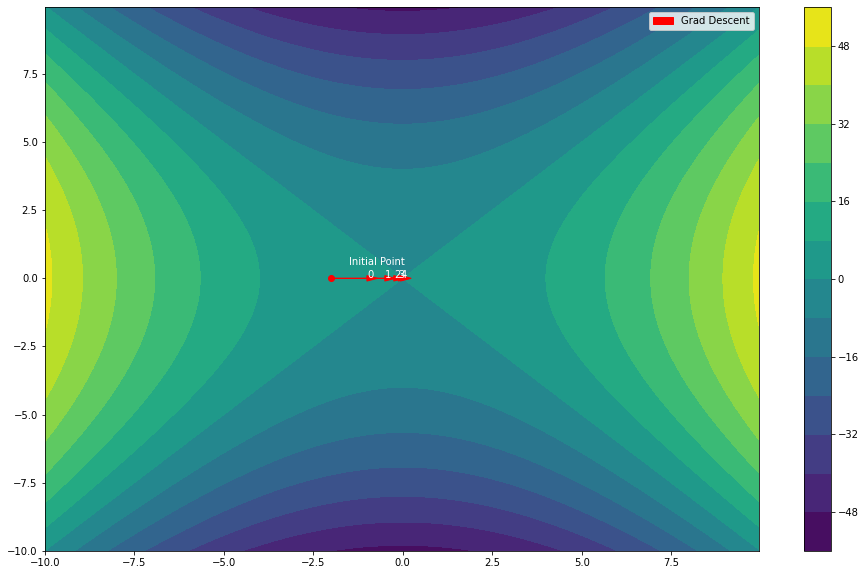

In [10]:
f = QuadFunc(a= 1.0, b= -1.0, c=0., d=0., e=0.) #instantiate quad function class
init = torch.tensor([-2.0,0.0]) #Starting points
regGD = GradientDescent(lr = 0.5, b1=0, b2=0) #instantiate gradient descent class, turned off momentum and ADAM
steps = 5
path = runOptim(init, regGD, f, steps)
showPath(f, init, [path], ['Grad Descent'], ['r'], levels=15)

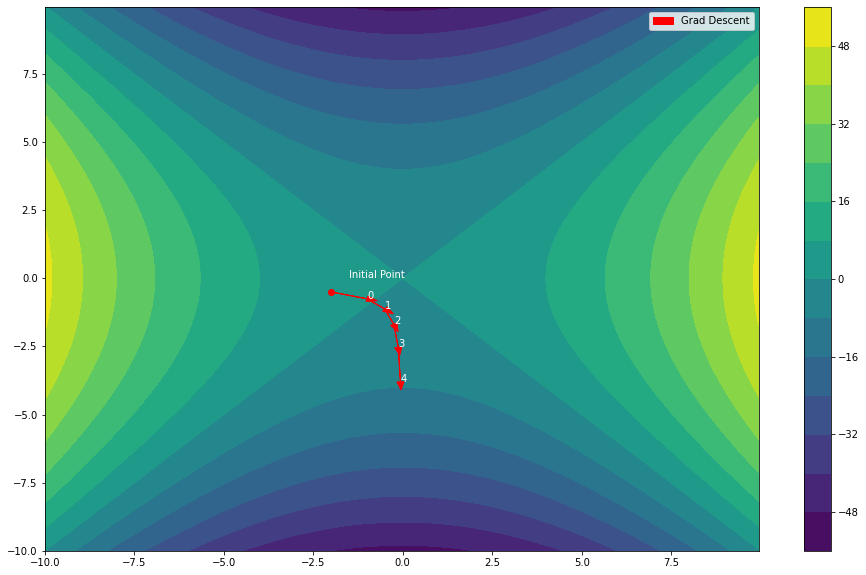

In [11]:
f = QuadFunc(a= 1.0, b= -1.0, c=0., d=0., e=0.) #instantiate quad function class
init = torch.tensor([-2.0, -0.5]) #Starting points
regGD = GradientDescent(lr = 0.5, b1=0, b2=0) #instantiate gradient descent class, turned off momentum and ADAM
steps = 5
path = runOptim(init, regGD, f, steps)
showPath(f, init, [path], ['Grad Descent'], ['r'], levels=15)

So the vanilla gradient descent is heavily dependent on the initial points and can potentially take us to the saddle point instead the minima. Converging at global minima is essential for minimizing our loss function.

3. Gradient descent on convex function $f(x,y) = x^2 + y^2 -0.8xy +x +y$

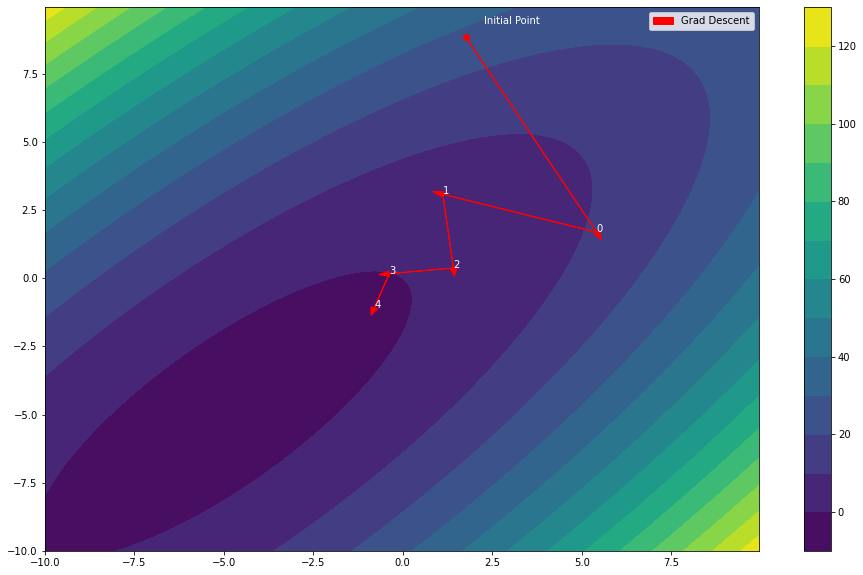

In [5]:
a = 1/ torch.sqrt(torch.tensor(2.0))
ellipsoid = QuadFunc(a,a,-0.8*a,a,a)

init = torch.matmul(torch.tensor([[a,a],[-a,a]]),torch.tensor([-5.0,7.5]))
steps = 5
regGD = GradientDescent(lr = 1.2, b1=0, b2=0)
path = runOptim(init, regGD, ellipsoid, steps)
showPath(ellipsoid, init, [path], ['Grad Descent'], ['r'], 15)


In the above example, gradient descent is moving along the steepest descent however, it's ping-ponging back and forth on its way. But we rather have a trajectory that takes us in a more smoother way.

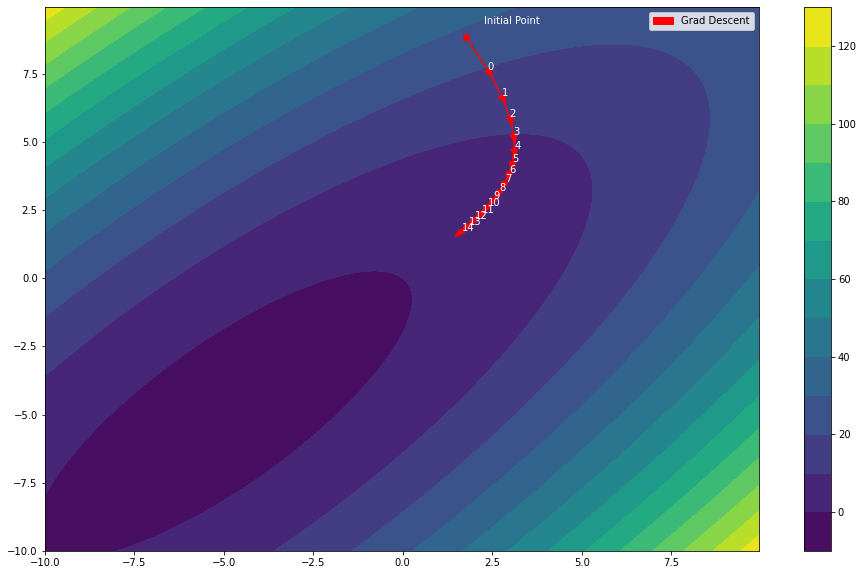

In [6]:
#set the lr=0.2 and steps = 15, yet doesn't reach the minimum but is in the direction of steepest descent that only increases the running time.

a = 1/ torch.sqrt(torch.tensor(2.0))
ellipsoid = QuadFunc(a,a,-0.8*a,a,a)

init = torch.matmul(torch.tensor([[a,a],[-a,a]]),torch.tensor([-5.0,7.5]))
steps = 15
regGD = GradientDescent(lr = 0.2, b1=0, b2=0)
path = runOptim(init, regGD, ellipsoid, steps)
showPath(ellipsoid, init, [path], ['Grad Descent'], ['r'], 15)


4. Comparing Newton's method and gradient descent

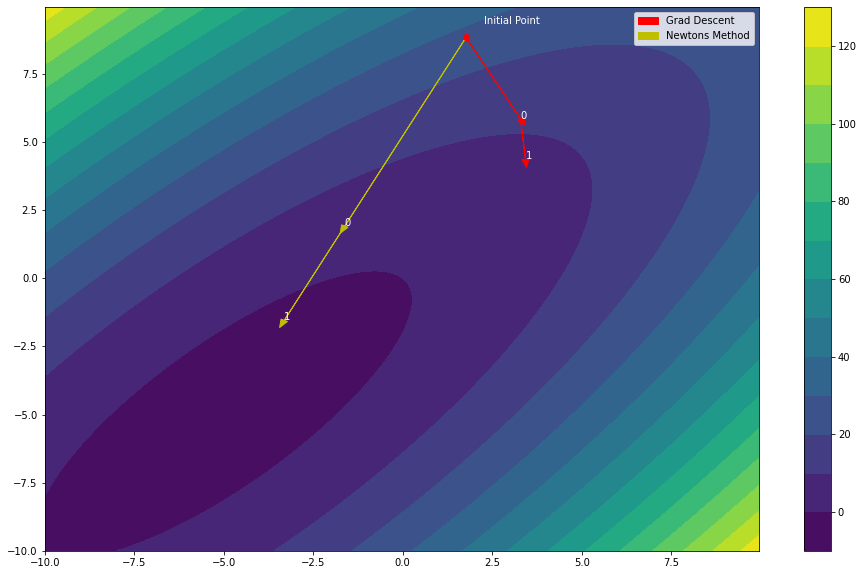

In [10]:
#set the lr=0.5 and steps = 2

a = 1/ torch.sqrt(torch.tensor(2.0))
ellipsoid = QuadFunc(a,a,-0.8*a,a,a)

init = torch.matmul(torch.tensor([[a,a],[-a,a]]),torch.tensor([-5.0,7.5]))
steps = 2
regGD = GradientDescent(lr = 0.5, b1=0, b2=0)
newMT = Newtons(lr=0.5)
path = runOptim(init, regGD, ellipsoid, steps)
path2 = runOptim(init, newMT,ellipsoid,steps)
showPath(ellipsoid, init, [path,path2], ['Grad Descent', 'Newtons Method'], ['r','y'], 15)